In [10]:
import os
import torch

import numpy as np

from CODE.AttentionDCA_python.src.new_plot_functions import graphAtt


cwd = os.getcwd()
print(cwd)


filename = cwd + '/CODE/DataAttentionDCA/data/lisa_data/HK_in_Concat_nnn.fasta'
structfile = cwd + '/CODE/DataAttentionDCA/data/lisa_data/HK-RR_old_processed.dat'


/home/ale_durso/Documents/EPFL/MA5/master_project/Attention DCA


In [11]:
def read_tensor_from_txt(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    # Read the dimensions from the first line
    dims = list(map(int, lines[0].strip().split()))
    
    # Initialize a list to hold the tensor data
    tensor_data = []
    
    current_slice = []
    for line in lines[1:]:
        line = line.strip()
        if line.startswith("Slice"):
            if current_slice:  # If there is an existing slice, save it
                tensor_data.append(current_slice)
                current_slice = []
        elif line:  # Process non-empty lines
            current_slice.append(list(map(float, line.split(','))))
    
    if current_slice:  # Append the last slice
        tensor_data.append(current_slice)
    
    # Convert the list back into a tensor with the original dimensions
    tensor = torch.tensor(tensor_data).view(*dims)
    return tensor




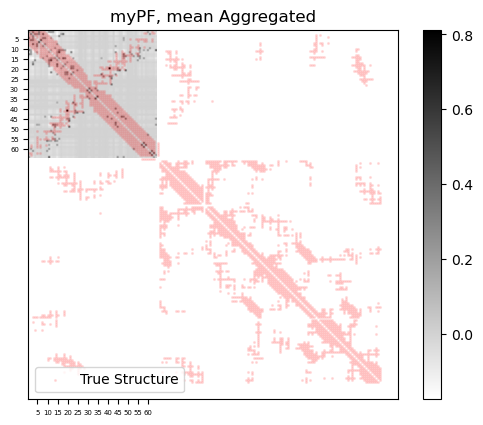

In [12]:
import torch
from CODE.AttentionDCA_python.src.model import AttentionModel
#from CODE.AttentionDCA_python.src.plot_functions import graphAtt

loss_type = 'without_J'

family = 'HK_alone_nomasks'
H = 32
d= 23
H1=H2=0
N = 64
q = 22
domain1_end = 0

device = 'cpu'
n_epochs = 200
K_torch = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}/K_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
Q_torch = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}/Q_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
V_torch = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}/V_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))

# Now create a model with matching H, d, N, q:
H, d, N = Q_torch.shape
q = V_torch.shape[1]
model = AttentionModel(
    H=H, d=d, N=N, q=q, 
    lambd=0.001, 
    index_last_domain1=0, 
    H1=0,
    H2=0,
)
model = model.to("cpu")  # or .cuda()

# Load parameters
with torch.no_grad():
    model.Q.copy_(Q_torch)
    model.K.copy_(K_torch)
    model.V.copy_(V_torch)

# Now you can directly call graphAtt with the model
ticks = np.arange(0, N, 5)
graphAtt(model, model.Q, model.K, model.V,
         filestruct=structfile,
         PFname="myPF",
         ticks=ticks,
         k=10,
         version='mean',
         APC=True,
         show_all_heads=False,
         index_last_domain1=0,
         H1=0, 
         H2=0)


In [15]:
from CODE.AttentionDCA_python.src.model_sep_size_heads import MultiDomainAttentionSubBlock
model = MultiDomainAttentionSubBlock(
        H=H, d=d, N=N, q=q,
        domain1_end=domain1_end,
        
        H1 = H1,H2=H2
    ).to(device)
model.Q.data = Q32_23_w_mask
model.K.data = K32_23_w_mask
model.V.data = V32_23_w_mask

65


/tmp/ipykernel_78399/2676249391.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


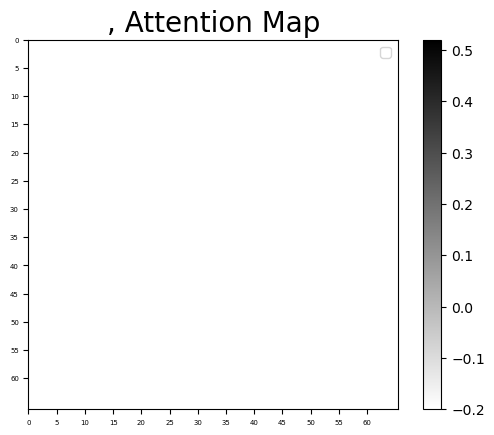

In [16]:
from CODE.AttentionDCA_python.src.dcascore import correct_APC
import matplotlib.pyplot as plt



def compute_e_sel_subblock(model, head_idx, domain='domain1'):
    """
    Compute the raw attention logits e_sel for a single head in the given domain block.
    domain ∈ {'domain1', 'domain2', 'inter'}

    Returns: e_sel (logits) as a 2D matrix
      - domain1 => shape (L1, L1)
      - domain2 => shape (L2, L2)
      - inter   => shape (L1, L2)
    """
    Q = model.Q[head_idx]  # shape (d, N)
    K = model.K[head_idx]  # shape (d, N)

    L1 = model.N_alpha
    L2 = model.N_beta
    start2 = model.domain2_start

    if domain == 'domain1':
        # Q_sel, K_sel => shape (d, L1)
        Q_sel = Q[:, :L1]
        K_sel = K[:, :L1]
        # e_sel => (L1, L1)
        e_sel = torch.einsum('di,dj->ij', Q_sel, K_sel)



    return e_sel
L1 = 65
k = 1000
A = torch.zeros(model.H1, L1, L1, device=device)

N = A.shape[1]
for h in range(0, model.H1):
    e_sel = compute_e_sel_subblock(model, h, domain='domain1')
    # e_sel: (L1,L1)
    sf = torch.nn.functional.softmax(e_sel, dim=1)
    A[h, 0:L1, 0:L1] = sf
    A[h, 0:L1, 0:L1].fill_diagonal_(0)
if True:
    A = A * A  # Element-wise square
    
if k >= N * (N - 1) / 2:
         M = torch.mean(A, dim=0)  # Shape: (N, N)


_A = torch.zeros(H1, L1, L1, device=A.device, dtype=A.dtype)
    
for h in range(H1):
    # Flatten the h-th attention matrix
    A_h = A[h].flatten()  # Shape: (N*N,)
    
    # Get top-k values and their indices
    vmins, idxs = torch.topk(A_h, k, largest=True, sorted=False)  # Shape: (k,)
    
    # Convert flat indices to 2D indices
    i_indices = idxs // N
    j_indices = idxs % N
    
    # Assign the top-k values to _A
    _A[h, i_indices, j_indices] = vmins



sum_A = _A.sum(dim=0)  # Shape: (N, N)
count_A = (_A != 0).sum(dim=0)  # Shape: (N, N)
M = torch.zeros(L1, L1, device=A.device, dtype=A.dtype)
mask = count_A > 0
M[mask] = sum_A[mask] / count_A[mask]
    

M = (M + M.transpose(0, 1)) / 2  # Symmetrize

M = correct_APC(M)


ticks = np.arange(0, N, 5)
print(N)
ms = 100 / N
# Replace diagonal elements with the mean of M
mean_M = torch.mean(M)
for i in range(M.size(0)):
    M[i, i] = mean_M

# Convert M to NumPy for plotting
Am = M.cpu().detach().numpy()

# Replace diagonal elements with the mean of M
mean_M = torch.mean(M)
for i in range(M.size(0)):
    M[i, i] = mean_M

# Convert M to NumPy for plotting
Am = M.cpu().detach().numpy()
#print(Am)

# Display the Attention Map
plt.imshow(Am, cmap='gray_r', vmin = -0.2, vmax = 0.52)#, aspect='auto')
plt.colorbar()#(shrink=0.7, aspect=10)
# Retrieve and adjust true structure coordinates

# Set axis ticks and labels
plt.xticks(ticks - 1, ticks, fontsize=5)
plt.yticks(ticks - 1, ticks, fontsize=5)
# Set plot title
plt.title(f", Attention Map", fontsize=20)
#save the image
#plt.savefig(f"AttentionMap_{PFname}_mean.pdf")
# Add colorbar with specified shrink and aspect

# Add legend
plt.legend()